### Import 4MuLa
* update `root_dir_path` below
* 4MuLA Large: 96,458 songs distributed by 15,310 artists in 76 genres
All music are organized by acoustic features in individual folders
* 4MuLA Small: 9,661 songs distributed by 491 artists in 51 genres
Music of Top 500 artists and only melspectrogram as acoustic feature
* 4MuLA Tiny: 1,988 songs distributed by 93 artists in 27 genres
Music of Top 100 artists and only melspectrogram as acoustic feature


In [93]:
import pandas as pd
import numpy as np
import librosa
import librosa.display
import IPython.display
from numpy import argmax
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import matplotlib.colors as mcolors
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from google.colab import drive
drive.mount('/content/drive')
# Update this string to your path
root_dir_path = '/content/drive/MyDrive/'
genres = ['Blues', 'Classic', 'Country', 'Disco', 'Hip Hop', 'Jazz', 'Heavy Metal', "Pop/Rock", "Reggaeton"]

%cd '/content/drive/MyDrive/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive


## Exploratory Data Analysis
* examines class distribution
* examines word counts for standardization
* "Pop/Rock" is one class, will need to augment final 1x9 categorical array to 1x10 for multimodal concatentation



### Data Snapshot

In [2]:
import pandas as pd
df_metadata = pd.read_parquet('4mula_small.parquet')
df_metadata.head()

,music_id,music_name,music_lang,music_lyrics,art_id,art_name,art_rank,main_genre,related_genre,related_art,related_music,musicnn_tags,melspectrogram
0,3ade68b6gc207fda3,I've Got To See You Again,en,Line on your face don't bother me\nDown in my ...,3ade68b6gfd79eda3,Norah Jones,353,Jazz,"['Jazz', 'Blues', 'Soul Music', 'Country', 'Ro...","[{'id': '3ade68b6g9a3beda3', 'name': 'Joss Sto...","[{'id': '3ade68b7gdddfcea3', 'name': 'Ten Phan...","['piano','drums','slow']","[[136.96524, 135.869965, 118.730804, 133.62802..."
1,3ade68b8g9410afa3,New Perspective,en,I feel the salty waves come in\nI feel them cr...,3ade68b6g2480fda3,Panic! At The Disco,154,Alternative Rock,"['Rock Alternativo', 'Pop/Punk', 'Pop/Rock', '...","[{'id': '3ade68b6gc5baeda3', 'name': 'Fall Out...","[{'id': '3ade68b7gc6144ea3', 'name': 'Wake Me ...","['rock','pop','guitar']","[[6.28145981, 1.50680351, 0.260610491, 0.17753..."
2,3ade68b7gb67d7ea3,Renúncia,pt-br,Hoje não existe nada mais entre nós\nSomos dua...,3ade68b5gef48eda3,Nelson Gonçalves,446,MPB,"['MPB', 'Velha Guarda', 'Romântico', 'Samba', ...","[{'id': '3ade68b5gf058eda3', 'name': 'Orlando ...","[{'id': '3ade68b6gbab1fda3', 'name': 'As Rosas...","['male','classical','male vocal']","[[0.905277014, 0.33714968, 0.210445538, 0.1545..."
3,3ade68b8gcd12d0b3,Good Form,en,"Eardrummers\nUh, uh, huh, uh, huh\nUh, yo, hol...",3ade68b7gc2b61ea3,Nicki Minaj,421,Rap,"['Rap', 'Pop', 'Hip Hop', 'R&B', 'Dance', 'Ele...","[{'id': '3ade68b5g8d18eda3', 'name': 'Lil Wayn...",[],"['techno','electronic','beat']","[[2.005826, 0.721350968, 0.2188458, 0.23778049..."
4,3ade68b7g955b3ea3,Out Of Time,en,You don't know what's going on\nYou've been aw...,3ade68b6g28c9eda3,Rolling Stones,118,Classic Rock,"['Classic Rock', 'Rock', 'Blues', 'R&B', 'Hard...","[{'id': '3ade68b6g7d5aeda3', 'name': 'Mick Jag...","[{'id': '3ade68b7g9ae20ea3', 'name': 'Run Of T...","['guitar','vocal','drums']","[[0.200993568, 0.232473925, 0.227112547, 0.139..."


### Song Languages

<Axes: ylabel='music_lang'>

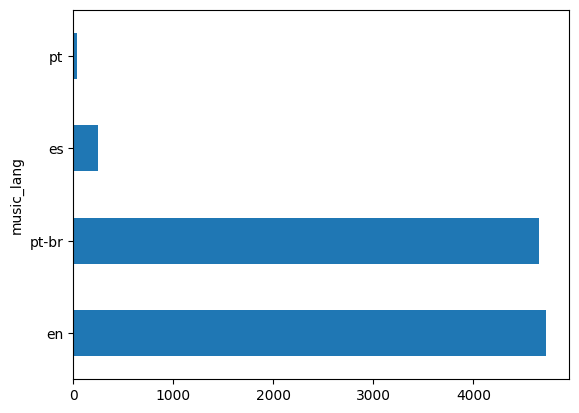

In [3]:
# mainly portugese and english music
df_metadata.value_counts('music_lang').plot(kind="barh")

### Song Genres

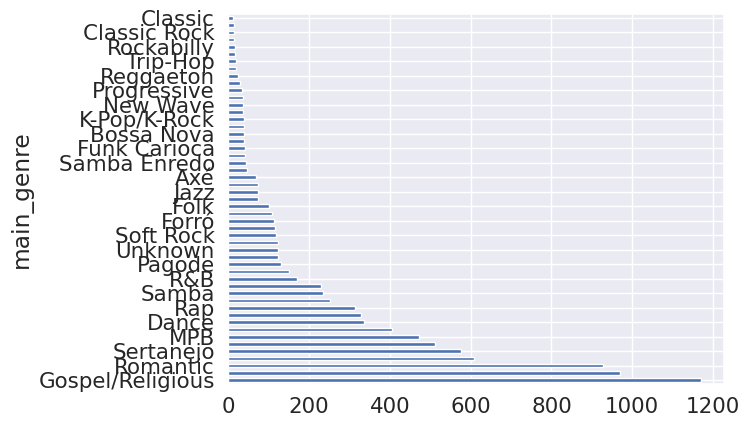

In [94]:
df = df_metadata
df.value_counts('main_genre').plot(kind="barh").yaxis.set_major_locator(plt.MultipleLocator(2))

Selects 10 genres defined in first cell **n = 1049**


In [97]:
# df = df.loc[df['main_genre'].isin(genres)]
df = df_metadata.loc[df['main_genre'].isin(genres)]
print(df.shape[0])
df.head()

1049


,music_id,music_name,music_lang,music_lyrics,art_id,art_name,art_rank,main_genre,related_genre,related_art,related_music,musicnn_tags,melspectrogram
0,3ade68b6gc207fda3,I've Got To See You Again,en,Line on your face don't bother me\nDown in my ...,3ade68b6gfd79eda3,Norah Jones,353,Jazz,"['Jazz', 'Blues', 'Soul Music', 'Country', 'Ro...","[{'id': '3ade68b6g9a3beda3', 'name': 'Joss Sto...","[{'id': '3ade68b7gdddfcea3', 'name': 'Ten Phan...","['piano','drums','slow']","[[136.96524, 135.869965, 118.730804, 133.62802..."
5,3ade68b8gb59f30b3,Turn It Up,en,But don't be alarmed\nWhen the lights come on\...,3ade68b6g415aeda3,Sean Paul,321,Hip Hop,"['Hip Hop', 'Reggae', 'Rap', 'Black Music', 'D...","[{'id': '3ade68b6g28abeda3', 'name': 'Martin S...",[],"['techno','electronic','beat']","[[0.00925674196, 0.0272453353, 0.433711052, 4...."
8,3ade68b7g69ca3ea3,Ain't Got No/I Got Life,en,"Ain't got no home, ain't got no shoes\nAin't g...",3ade68b6g8529eda3,Nina Simone,429,Jazz,"['Jazz', 'Blues', 'Soul Music', 'Romântico', '...","[{'id': '3ade68b6g11baeda3', 'name': 'Ella Fit...","[{'id': '3ade68b8g9205dfa3', 'name': 'Someone ...","['guitar','male','male vocal']","[[6.49159908, 1.59826362, 0.00176818972, 0.000..."
25,3ade68b7g2ad15ea3,Vivir Sin Aire,es,Como quisiera poder vivir sin aire \nComo quis...,3ade68b5g6847eda3,Maná,480,Pop/Rock,"['Pop/Rock', 'Rock', 'Romântico', 'Pop', 'K-Po...","[{'id': '3ade68b5gea27eda3', 'name': 'Juanes'}...","[{'id': '3ade68b6g394feda3', 'name': 'Corazón ...","['guitar','vocal','slow']","[[622.505798, 543.775146, 474.074524, 208.6196..."
27,3ade68b8gffcd8fa3,Better Today,en,"Whoa oh, whoa oh. \nWhoa oh, whoa oh. \nWhoa o...",3ade68b6g2992fda3,Ne-yo,339,Hip Hop,"['Hip Hop', 'Black Music', 'R&B', 'Pop', 'Danc...","[{'id': '3ade68b6geff9eda3', 'name': 'Justin T...","[{'id': '3ade68b8g89a5bfa3', 'name': 'Talking ...","['pop','electronic','techno']","[[103.667244, 35.9100113, 16.6402645, 21.92423..."


Saves DataFrame with English only songs from 9 genres

Total Samples: 1049


main_genre
Pop/Rock       511
Hip Hop        330
Jazz            73
Heavy Metal     36
Blues           30
Reggaeton       24
Country         20
Disco           14
Classic         11
Name: count, dtype: int64

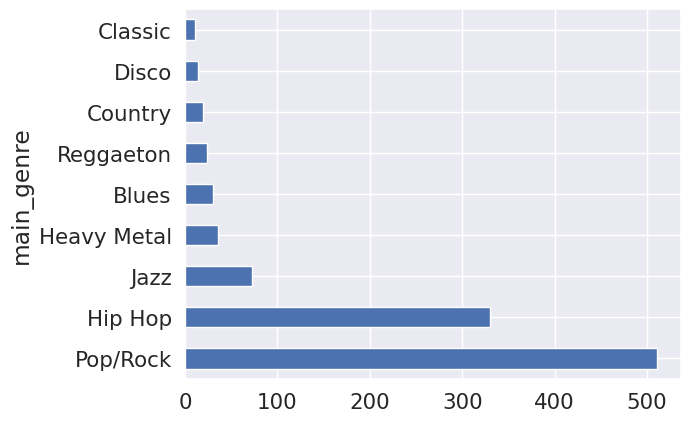

In [98]:
df.value_counts('main_genre').plot(kind="barh")
df = df.reset_index(drop=True)
df.to_csv(f"{root_dir_path}/9_genres_4MuLa_1038.csv")
print(f"Total Samples: {df.shape[0]}")
df.value_counts('main_genre')

## Finetuned BERT Model

### Download BERT base model

In [8]:
!pip install sentence_transformers
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('bert-base-multilingual-uncased')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 5.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/672M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

### Preprocessing
* remove new line character from lyrics
* removes outlier word counts (>3σ)

#### Remove Outlier word counts
* **n=934**
* saves dataframe to *root_dir_path/English_10_genres_4MuLa_word_count_outliers_removed*




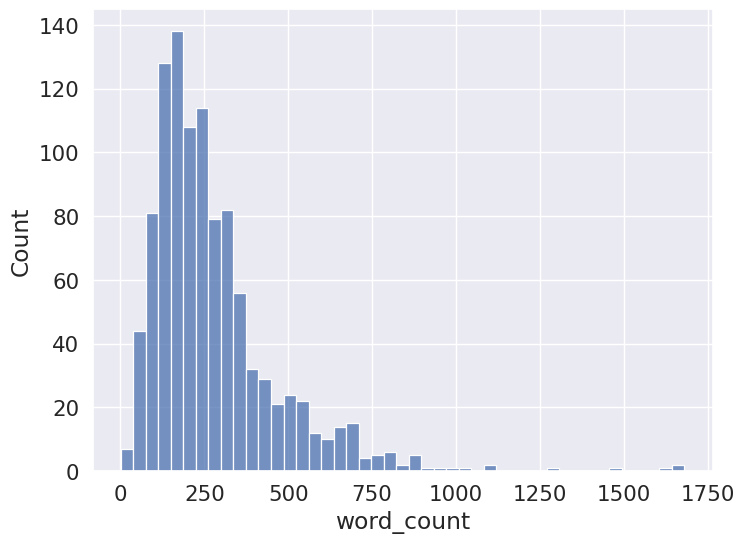

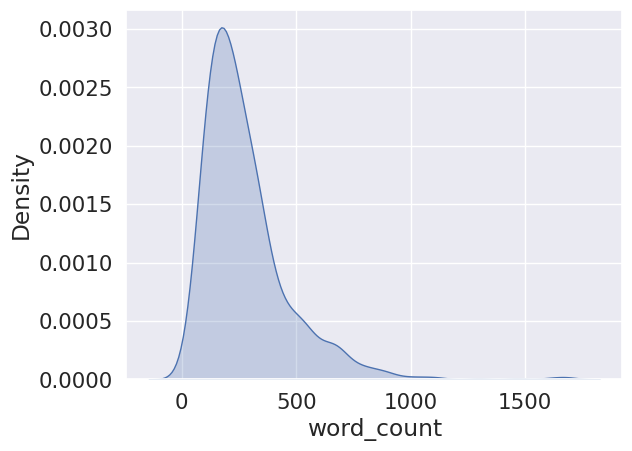

count    1049.000000
mean      277.819828
std       194.910263
min         1.000000
25%       151.000000
50%       229.000000
75%       343.000000
max      1680.000000
Name: word_count, dtype: float64


In [99]:
import seaborn as sns

df["word_count"] = df["music_lyrics"].str.split().str.len()

plt.figure(figsize = (8,6),)
sns.histplot(df["word_count"], )
plt.show()
sns.kdeplot(df["word_count"], fill=True)
plt.show()
print(df["word_count"].describe())

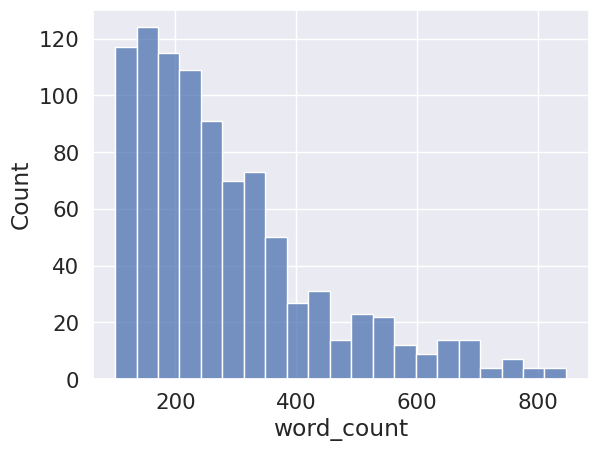

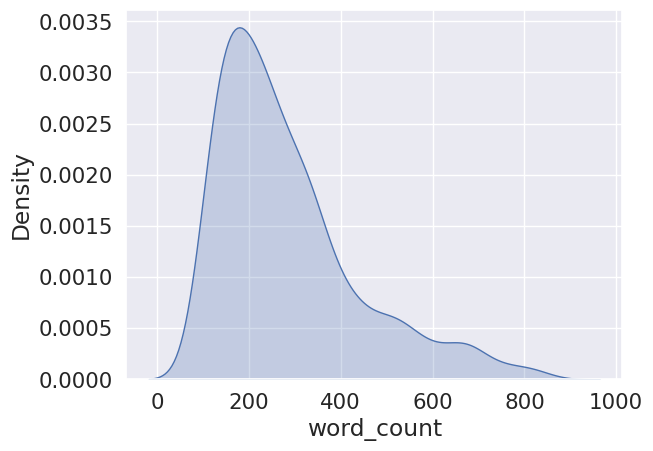

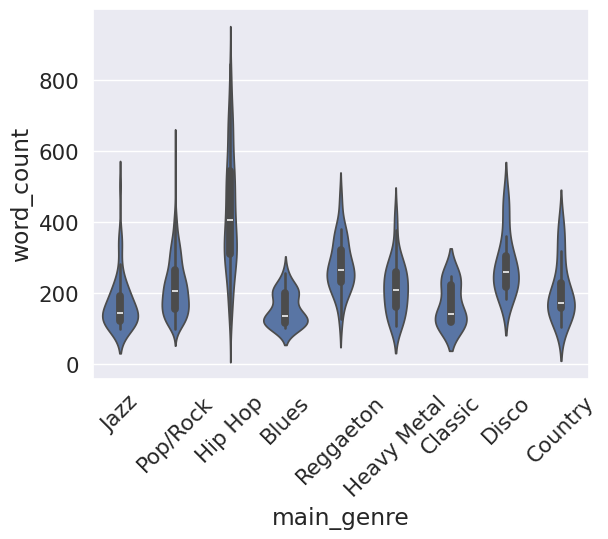

count    934.000000
mean     284.664882
std      154.468879
min      100.000000
25%      170.000000
50%      244.000000
75%      349.000000
max      846.000000
Name: word_count, dtype: float64
removed word count from dataframe


In [100]:
mean = 277
std_dev = 195
MIN_WORDS = 100
MAX_WORDS = mean + 3*std_dev

df = df[df["word_count"] <= MAX_WORDS]
df = df[df["word_count"] >= MIN_WORDS]
df.to_csv(f"{root_dir_path}/10_genres_4MuLa_word_count_outliers_removed.csv")
df = df.reset_index(drop=True)
sns.histplot(df["word_count"], )
plt.show()
sns.kdeplot(df["word_count"], fill=True)
plt.show()

sns.violinplot( y=df["word_count"], x=df["main_genre"])
plt.xticks(rotation=45)
plt.show()
print(df["word_count"].describe())
df.drop("word_count", axis=1)
print("removed word count from dataframe")

#### New Data Spread

Total Samples: 934


main_genre
Pop/Rock       453
Hip Hop        306
Jazz            53
Heavy Metal     33
Blues           26
Reggaeton       24
Country         17
Disco           14
Classic          8
Name: count, dtype: int64

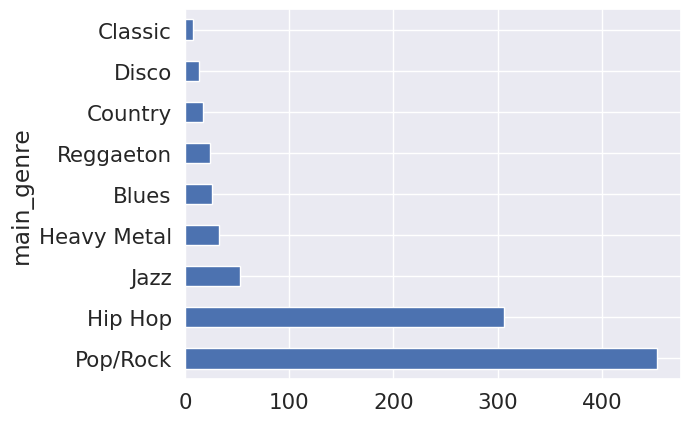

In [101]:
df.value_counts('main_genre').plot(kind="barh")
# df = df.reset_index(drop=True)
# df.to_csv(f"{root_dir_path}/9_genres_4MuLa_1038.csv")
print(f"Total Samples: {df.shape[0]}")
df.value_counts('main_genre')

#### Remove New-line Character
* can import dataframe to save loading time **(START HERE)**

In [102]:
# import dataframe to avoid putting dataset in RAM
# df = pd.read_csv(f"{root_dir_path}/English_10_genres_4MuLa_word_count_outliers_removed.csv")
lyric_corpus = df['music_lyrics']
print(lyric_corpus)
lyric_corpus = [x.replace('\\n', ' ') for x in lyric_corpus]
lyric_corpus[0]

0      Line on your face don't bother me\nDown in my ...
1      Ain't got no home, ain't got no shoes\nAin't g...
2      Como quisiera poder vivir sin aire \nComo quis...
3      Whoa oh, whoa oh. \nWhoa oh, whoa oh. \nWhoa o...
4      Te tenho com a certeza\nDe que você pode ir\nT...
                             ...                        
929    Eu vejo a vida melhor no futuro\nEu vejo isso ...
930    I can be an asshole of the grandest kind\nI ca...
931    Despencados de voos cansativos\nComplicados e ...
932    Eu vejo na Tv o que eles falam sobre o jovem n...
933    He's just a loner\nHe never says hello\nA frie...
Name: music_lyrics, Length: 934, dtype: object


"Line on your face don't bother me Down in my chair when you dance over me I can't help myself I've got to see you again  Late in the night when I'm all alone And I look at the clock and I know you're not home I can't help myself  I've got to see you again I could almost go there Just to watch you be seen I could almost go there Just to live in a dream  But no I won't go for any of those things To not touch your skin is not why I sing I can't help myself I've got to see you again  I could almost go there....  No I won't go to share you with them But oh even though I know where you've been I can't help myself I've got to see you again"

### Generate lyric embeddings

In [103]:
model = SentenceTransformer('bert-base-multilingual-uncased')
lyric_embeddings = model.encode(lyric_corpus)
lyric_embeddings_list = []
for i in range(len(lyric_embeddings)):
  lyric_embeddings_list.append(np.ravel(lyric_embeddings[i].tolist()))

#### t-SNE plot for a small sample of the dataset

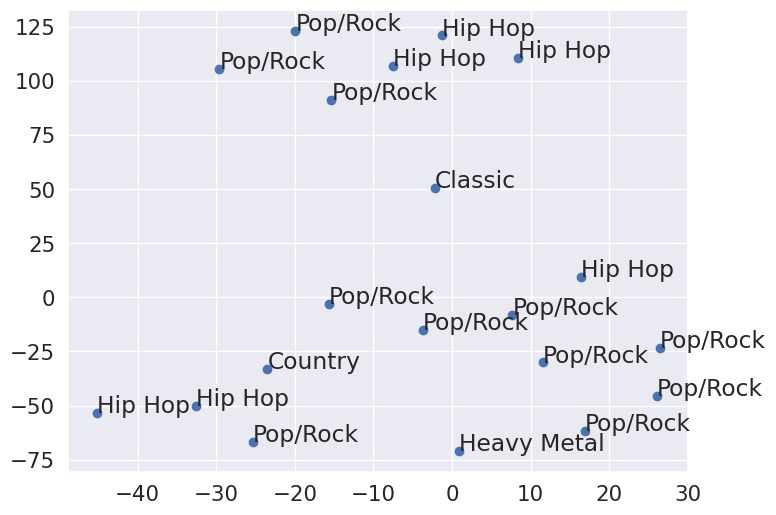

In [104]:
tsne_model = TSNE(n_components=2, random_state=0, perplexity=5)
tsne_data = tsne_model.fit_transform(np.array(lyric_embeddings_list[-20:]))
tsne_labels = df["main_genre"][-20:]

# Plot the t-SNE visualization
plt.figure(figsize = (8,6),)
plt.scatter(tsne_data[:, 0], tsne_data[:, 1])
for i, txt in enumerate(tsne_labels):
    plt.annotate(txt, (tsne_data[i, 0], tsne_data[i, 1]))
plt.show()

### Prepare Datasets
* defines training dataframe

In [105]:
train_df = df[['main_genre']]
train_df['lyric_embeddings'] = lyric_embeddings_list
# 1-hot encoding
train_df = pd.get_dummies(train_df, columns=['main_genre'])
train_df.tail()

<ipython-input-105-38ba1bf8ab2d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['lyric_embeddings'] = lyric_embeddings_list


,lyric_embeddings,main_genre_Blues,main_genre_Classic,main_genre_Country,main_genre_Disco,main_genre_Heavy Metal,main_genre_Hip Hop,main_genre_Jazz,main_genre_Pop/Rock,main_genre_Reggaeton
929,"[-0.3881511688232422, -0.07247958332300186, 0....",False,False,False,False,False,False,False,True,False
930,"[-0.10673467814922333, -0.27360013127326965, 0...",False,False,False,False,False,False,False,True,False
931,"[-0.25136417150497437, -0.2819937765598297, 0....",False,False,False,False,False,True,False,False,False
932,"[-0.22033768892288208, -0.1894945353269577, 0....",False,False,False,False,False,False,False,True,False
933,"[-0.21644583344459534, -0.31494730710983276, 0...",False,False,False,False,True,False,False,False,False


### Data loader
* returns lyrics and the corresponding labels
* 80/10/10 *train/validation/test* dataset split
* batch size = 32

In [106]:
genres = ['main_genre_Blues', 'main_genre_Classic', 'main_genre_Country',
          'main_genre_Disco', 'main_genre_Hip Hop', 'main_genre_Jazz',
          'main_genre_Heavy Metal', 'main_genre_Pop/Rock', 'main_genre_Reggaeton']

class CustomImageTextDataset(Dataset):
    def __init__(self, csv_file):
        self.data = csv_file

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        seed = 42
        torch.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        self.data = self.data.reset_index(drop=True)
        lyrics = self.data['lyric_embeddings'][idx]
        lyrics = torch.tensor(lyrics, dtype=torch.float32)
        labels = torch.tensor(self.data[genres].iloc[idx],dtype=torch.float32)
        return lyrics, labels

train_data = train_df.sample(frac=0.80, random_state=42)
validation_data = train_df.sample(frac=0.10, random_state=42)
test_data = train_df.sample(frac=0.10, random_state=42)

traindata = CustomImageTextDataset(
    csv_file=train_data,
)

validationdata = CustomImageTextDataset(
    csv_file=validation_data,
)

testdata = CustomImageTextDataset(
    csv_file=test_data,
)

# Create a data loader with 32 data points as the batch size
batch_size = 32
train_loader = DataLoader(traindata, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validationdata, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testdata, batch_size=batch_size, shuffle=True)

### Bert encoder based ANN

In [195]:
class LyricClassifier(nn.Module):

    def __init__(self, num_classes):
        super(LyricClassifier, self).__init__()
        self.num_classes = num_classes
        # berts last dense layer outputs 768
        self.linear1 = nn.Linear(768, 512)
        self.dropout1 = nn.Dropout(p=0.2)
        self.linear2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(p=0.3)
        self.linear3 = nn.Linear(256,128)
        self.dropout3 = nn.Dropout(p=0.4)
        self.linear4 = nn.Linear(128,num_classes)
        # best: 0.2, 0.3, 0.4 || 0.3,4,5

    def forward(self, x):
        x = torch.relu(self.linear1(x))
        x = self.dropout1(x)
        x = torch.relu(self.linear2(x))
        x = self.dropout2(x)
        x = torch.relu(self.linear3(x))
        x = self.dropout3(x)
        out = torch.relu(self.linear4(x))
        #out = F.softmax(x, dim=1)

        return out

#### Function def.
* calculates the accuracy from model output

In [73]:
def calc_accuracy(batch_inputs, model_outputs, targets):
  y_pred = []
  y_true = []
  # calculate accuracy
  try:
    y_pred.extend(model_outputs.cpu().detach().numpy())
    y_true.extend(targets.cpu().detach().numpy())
  except IndexError:
    print(batch_inputs)
    print(i)
    print(batch_inputs.shape)
  predictions = []
  for i in y_pred:
    genre = np.argmax(i)
    predictions.append(genres[genre].replace("main_genre_", ""))

  ground_truth = []
  for i in y_true:
    genre = np.argmax(i)
    ground_truth.append(genres[genre].replace("main_genre_", ""))
  return accuracy_score(ground_truth, predictions)

#### Train the Model

In [196]:
model = LyricClassifier(num_classes = len(genres))
model = model.float()

# Transfer Model to GPU if available
if torch.cuda.is_available():
    model = model.cuda()

batch_size = 32
epochs = 500
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001, weight_decay=0.000001)
# optimizer = optim.Adam(model.parameters(), lr = 0.001, weight_decay=0.0001)
training_loss = []
validation_loss = []
training_accuracy = []
validation_accuracy = []
best_train_accuracy = 0
best_val_accuracy = 0
last_epoch = 0
for epoch in range(epochs):
    val_accuracy = 0
    train_accuracy = 0
    validation_accuracy.append(val_accuracy)
    training_accuracy.append(train_accuracy)
    ind = len(validation_accuracy)-1

    train_loss = 0.0
    for inputs, targets in train_loader:
      # Transfer Data to GPU if available
      if torch.cuda.is_available():
          inputs, targets = inputs.cuda(), targets.cuda()

      optimizer.zero_grad()
      #print(inputs.size())
      outputs = model(inputs)

      # calculate loss
      loss = criterion(outputs, targets)
      # credit assignment
      loss.backward()
      # update model weights
      optimizer.step()
      train_loss += loss.item()
      # calculate accuracy
      train_accuracy = calc_accuracy(inputs, outputs, targets)
      training_accuracy[ind] = train_accuracy
      best_train_accuracy = train_accuracy if train_accuracy > best_train_accuracy else best_train_accuracy

    val_loss = 0.0
    for inputs, targets in validation_loader:
      # Transfer Data to GPU if available
      if torch.cuda.is_available():
          inputs, targets = inputs.cuda(), targets.cuda()

      # optimizer.zero_grad()
      #print(inputs.size())
      outputs = model(inputs)
      # calculate loss
      loss = criterion(outputs, targets)
      # credit assignment
      loss.backward()
      # update model weights
      # optimizer.step()
      val_loss += loss.item()
      # calculate accuracy
      val_accuracy = calc_accuracy(inputs, outputs, targets)
      validation_accuracy[ind] = val_accuracy
      best_val_accuracy = val_accuracy if val_accuracy > best_val_accuracy else best_val_accuracy
    if epoch >= 5 and epoch % 5 == 0:
      print(f'Epoch {epoch+1} \t\t Best Validation Accuracy: {best_val_accuracy}')

    # updates metrics
    validation_loss.append(val_loss / len(validation_loader))
    training_loss.append(train_loss / len(train_loader))
    print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss / len(train_loader)} \t\t Validation Loss: {val_loss / len(validation_loader)}')
    # else:
    #   print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss / len(train_loader)}')

    torch.save(model.state_dict(), '/content/drive/MyDrive/saved_model_lyric_only_10_genres_50ep.pth')
    last_epoch += 1
    # early breakout
    eps = 1e-6
    if len(training_loss) >= 2 and abs(training_loss[len(training_loss)-1] - training_loss[len(training_loss)-2]) < eps:
      break

# for i in range(len(validation_accuracy)):
#   validation_accuracy[i] /= last_epoch
#   training_accuracy[i] /= last_epoch
#   best_train_accuracy = training_accuracy[i] if training_accuracy[i] > best_train_accuracy else best_train_accuracy
#   best_val_accuracy = validation_accuracy[i] if validation_accuracy[i] > best_val_accuracy else best_val_accuracy

print(f"\033[1mBest Training Accuracy:\033[0m {best_train_accuracy}")
print(f"\033[1mBest Validation Accuracy:\033[0m {best_val_accuracy}")

Epoch 1 		 Training Loss: 1.7086726526419322 		 Validation Loss: 1.5303846995035808
Epoch 2 		 Training Loss: 1.2841537197430928 		 Validation Loss: 1.3583470185597737
Epoch 3 		 Training Loss: 1.0651529803872108 		 Validation Loss: 1.5058693091074626
Epoch 4 		 Training Loss: 0.9863787479698658 		 Validation Loss: 1.4048484563827515
Epoch 5 		 Training Loss: 0.8895034864544868 		 Validation Loss: 1.3261852661768596
Epoch 6 		 Best Validation Accuracy: 0.625
Epoch 6 		 Training Loss: 0.8233087199429671 		 Validation Loss: 1.2778284947077434
Epoch 7 		 Training Loss: 0.7743596167614063 		 Validation Loss: 1.227786382039388
Epoch 8 		 Training Loss: 0.7313386431584755 		 Validation Loss: 1.2079195578893025
Epoch 9 		 Training Loss: 0.6874459274113178 		 Validation Loss: 1.234541932741801
Epoch 10 		 Training Loss: 0.6447468201319376 		 Validation Loss: 1.2714726130167644
Epoch 11 		 Best Validation Accuracy: 0.65625
Epoch 11 		 Training Loss: 0.6077156054476897 		 Validation Loss: 1.2560

#### Loss Plot

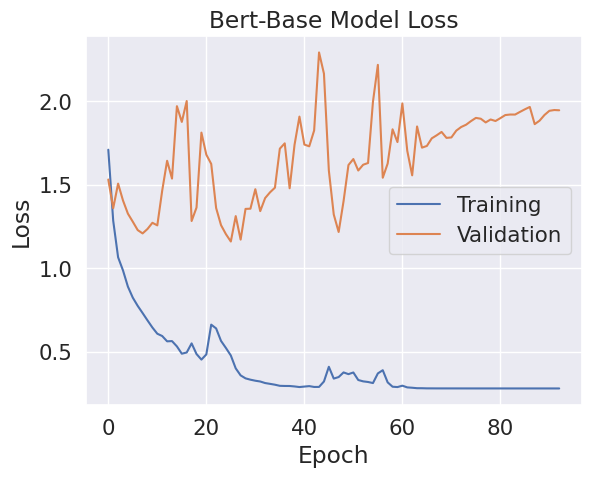

In [197]:
plt.title("Bert-Base Model Loss")
plt.plot(training_loss)
plt.plot(validation_loss)
plt.legend(["Training", "Validation"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

#### Accuracy Plot

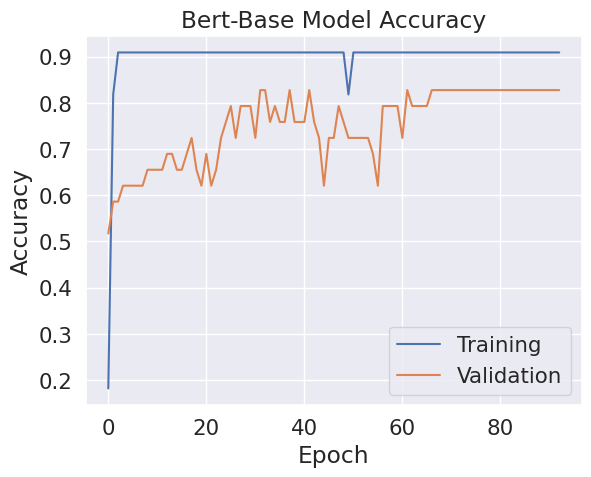

In [198]:
plt.title("Bert-Base Model Accuracy")
plt.plot(training_accuracy)
plt.plot(validation_accuracy)
plt.legend(["Training", "Validation"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

### Testing and evaluating the model using the saved weights

Testset Accuracy:  0.7634408602150538


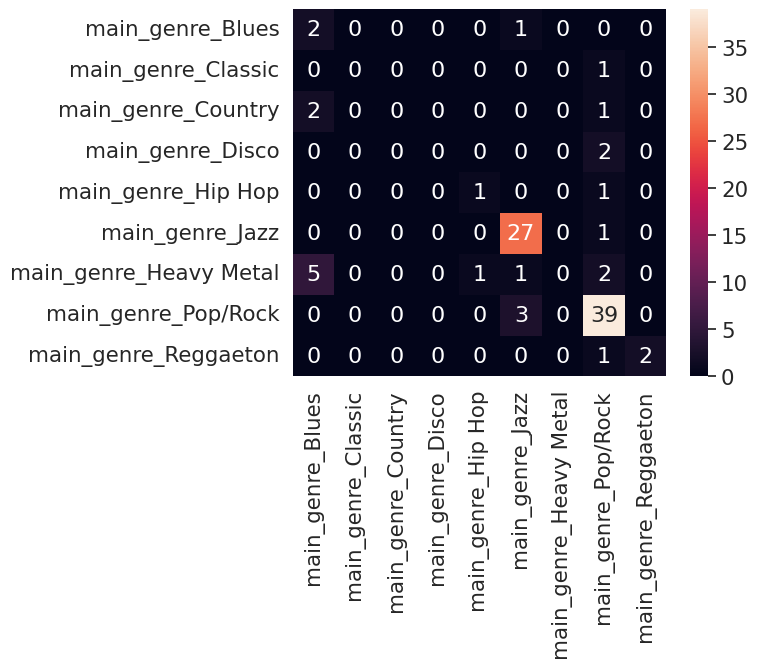

In [199]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load in a model
# best_model = LyricClassifier(num_classes = 10)
# best_model.load_state_dict(torch.load('/content/drive/MyDrive/multi_modal_genre_classifier/saved_model_lyric_only_10_genres_50ep.pth'))
# best_model.to(device)

best_model = model

best_model.eval()
y_pred = []
y_true = []
i = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        i += 1
        try:
          outputs = best_model(inputs)
          y_pred.extend(outputs.cpu().numpy())
          y_true.extend(labels.cpu().numpy())
        except IndexError:
          print(inputs)
          print(i)
          print(inputs.shape)

predictions = []
for i in y_pred:
  genre = np.argmax(i)
  predictions.append(genres[genre].replace("main_genre_", ""))

ground_truth = []
for i in y_true:
  genre = np.argmax(i)
  ground_truth.append(genres[genre].replace("main_genre_", ""))

# confusion matrix
accuracy = accuracy_score(ground_truth, predictions)
conf_matrix = confusion_matrix(ground_truth, predictions)
# print("predic vs ground truth")
# for i in range(len(ground_truth)):
#   print(predictions[i], ground_truth[i])

conf_matrix = np.round(conf_matrix, 2)
conf_matrix_df = pd.DataFrame(conf_matrix, columns=genres, index=genres)

print(f'\033[1mTestset Accuracy: \033[0m {accuracy}')

plt.figure(figsize = (8,7),)
sns.set(font_scale=1.4)
sns.heatmap(conf_matrix_df, annot=True, annot_kws={"size": 16},) # font size
plt.tight_layout()
plt.show()


In [ ]:
print('\nClassification Report:\n', classification_report(ground_truth, predictions))


Classification Report:
               precision    recall  f1-score   support

       Blues       1.00      1.00      1.00         1
     Country       0.00      0.00      0.00         3
       Disco       0.00      0.00      0.00         2
 Heavy Metal       0.50      0.50      0.50         2
     Hip Hop       0.96      1.00      0.98        23
        Jazz       0.50      1.00      0.67         4
    Pop/Rock       0.96      1.00      0.98        25
   Reggaeton       0.00      0.00      0.00         1

    accuracy                           0.89        61
   macro avg       0.49      0.56      0.52        61
weighted avg       0.82      0.89      0.85        61



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
